<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/vae/vae/notebooks/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from [pytorch/examples](https://github.com/pytorch/examples/blob/master/vae/main.py)

In [1]:
!nvidia-smi | head -n 10

Sun May 17 00:44:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+


In [0]:
%load_ext tensorboard

In [0]:
import os
import re
import glob
import random
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torchsummary import summary

In [4]:
!pip freeze | grep torch

torch==1.5.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.6.0+cu101


In [0]:
@dataclasses.dataclass(frozen=True)
class Config:
    # setting
    is_cuda: bool     = True
    seed: int         = 42
    # training
    lr: int           = 1e-4
    batch_size: int   = 256
    n_epochs: int     = 50
    log_interval: int = 50
    # dataset
    num_workers: int  = 4
    pin_memory: bool  = True
    # model
    nin: int          = 784
    nh: int           = 100
    nz: int           = 20

In [6]:
cfg = Config()
print(cfg)

Config(is_cuda=True, seed=42, lr=0.0001, batch_size=256, n_epochs=50, log_interval=50, num_workers=4, pin_memory=True, nin=784, nh=100, nz=20)


In [0]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [8]:
if cfg.is_cuda:
    print(f"set seed: {cfg.seed}")
    set_seed(cfg.seed)

set seed: 42


In [9]:
is_cuda = cfg.is_cuda and torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda else "cpu")
print(device)

cuda:0


In [0]:
def get_loader(cfg, mode, transform):
    assert mode in ["train", "test"], "set moode in ['train', 'test']"

    if mode == "train":
        loader = DataLoader(
            datasets.FashionMNIST("./data", train=True, download=True, transform=transform),
            batch_size=cfg.batch_size,
            shuffle=True,
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory
        )
    elif mode == "test":
        loader = DataLoader(
            datasets.FashionMNIST("./data", train=False, download=True, transform=transform),
            batch_size=cfg.batch_size,
            shuffle=False,
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory
        )

    return loader

In [0]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

In [12]:
train_loader = get_loader(cfg, "train", train_transforms)
test_loader  = get_loader(cfg, "test",  test_transforms)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


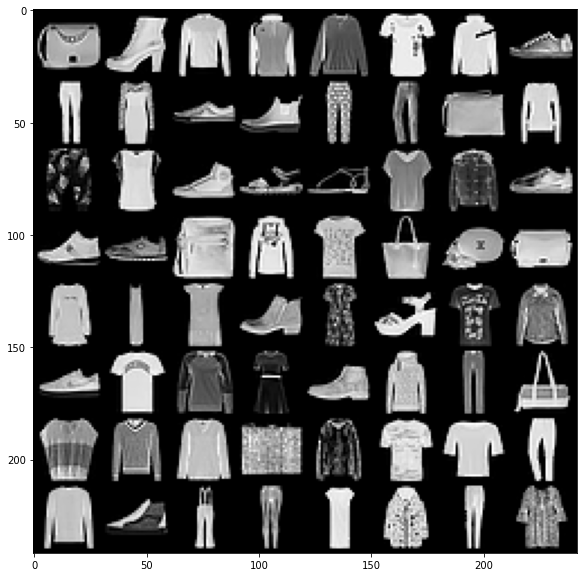

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(make_grid(next(iter(train_loader))[0][:64]).permute(1, 2, 0).numpy())

In [0]:
class VAE(nn.Module):
    def __init__(self, nin, nh, nz):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(nin, nh)
        self.fc_mu  = nn.Linear(nh, nz)
        self.fc_logvar = nn.Linear(nh, nz)
        self.fc2 = nn.Linear(nz, nh)
        self.fc3 = nn.Linear(nh, nin)

    def encode(self, x):
        # x: [batch_size, 784]
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        # z: [batch_size, nz]
        h2 = F.relu(self.fc2(z))
        recon = torch.sigmoid(self.fc3(h2))
        return recon

    def forward(self, x):
        # x:      [batch_size, 1, 28, 28]
        # return: [batch_size, 784]
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [0]:
model = VAE(cfg.nin, cfg.nh, cfg.nz)
model = model.to(device)

In [16]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 20]           2,020
            Linear-3                   [-1, 20]           2,020
            Linear-4                  [-1, 100]           2,100
            Linear-5                  [-1, 784]          79,184
Total params: 163,824
Trainable params: 163,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.62
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


In [0]:
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

In [0]:
def criterion(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="mean")

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [0]:
def train(loader, model, optimizer, epoch, log_interval):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = criterion(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % cfg.log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data))
            )
            
    print("====> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset))
    )

In [0]:
def test(loader, model, epoch, writer):
    model.eval()
    test_loss = 0
    batch_size = loader.batch_size
    with torch.no_grad():
        for i, (data, _) in enumerate(loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += criterion(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), "reconstruction_"+str(epoch)+".png", nrow=n)
                add_image_tensorboard(comparison.cpu(), epoch, writer, "recon")

    test_loss /= len(loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))

In [0]:
!rm -rf ./runs

In [22]:
%tensorboard --logdir ./runs

<IPython.core.display.Javascript object>

In [0]:
def add_image_tensorboard(tensor, epoch, writer, label):
    grid_tensor = make_grid(tensor, padding=1, normalize=True)
    # plt.imshow(np.transpose(grid_tensor.numpy(), (1, 2, 0)))
    # plt.axis("off")
    # fig = plt.gcf()
    # writer.add_figure(tag="temp", figure=fig, global_step=epoch, close=True)
    writer.add_image(label, grid_tensor, global_step=epoch)

In [24]:
writer = SummaryWriter()
sample_img_list = []
for epoch in range(1, cfg.n_epochs):
    train(train_loader, model, optimizer, epoch, cfg.log_interval)
    test(test_loader, model, epoch, writer)

    with torch.no_grad():
        sample = torch.randn(cfg.batch_size, cfg.nz).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(cfg.batch_size, 1, 28, 28), "sample_"+str(epoch)+".png")

        # add image to tensorboard
        n = min(sample.size(0), 16)
        add_image_tensorboard(
            sample.view(cfg.batch_size, 1, 28, 28).detach()[:n],
            epoch,
            writer,
            "sample"
        )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.242647
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.019080
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.012934
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.010963
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.008996
====> Epoch: 1 Average loss: 0.0198
====> Test set loss: 0.0081
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007999
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.006984
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.006570
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.005341
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.004970
====> Epoch: 2 Average loss: 0.0061
====> Test set loss: 0.0047
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.004788
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.004428
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.003988
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.003819
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.003543
====> Epoch: 3 Average loss: 0.0040
====> Test set loss: 0.0036
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.003445
Train Epoch: 4 [12800/60000 

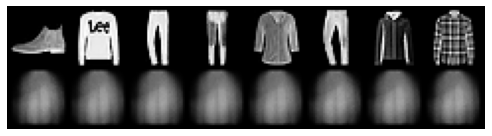

In [25]:
recon_img_list = sorted(glob.glob("reconstruction_*.png"),
                        key=lambda s: int(re.search(r"\d+", s).group()))

fig = plt.figure(figsize=(8, 2), tight_layout=True)
plt.axis("off")
ims = [[plt.imshow(Image.open(img_path), animated=True)] for img_path in recon_img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())